# Fraudulent Transactions

Task Develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns.

# STEPS:

## 1. Importing libraries and importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (13, 12)})
plt.figure(figsize=(14, 16));

<Figure size 1008x1152 with 0 Axes>

In [2]:
data = pd.read_csv('Fraud.csv')

data = next(data)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 2. Data Cleaning

In [3]:
data.shape

(1000000, 11)

In [4]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1000000 non-null  int64  
 1   type            1000000 non-null  object 
 2   amount          1000000 non-null  float64
 3   nameOrig        1000000 non-null  object 
 4   oldbalanceOrg   1000000 non-null  float64
 5   newbalanceOrig  1000000 non-null  float64
 6   nameDest        1000000 non-null  object 
 7   oldbalanceDest  1000000 non-null  float64
 8   newbalanceDest  1000000 non-null  float64
 9   isFraud         1000000 non-null  int64  
 10  isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 83.9+ MB


In [6]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### We'll try to drop the account names and see if they may be of importance later

In [7]:
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


## 3. Data Visualization and EDA

In [8]:
data.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [9]:
from sklearn.feature_selection import mutual_info_classif


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


In [10]:
X_temp = data.copy()
y_temp = X_temp.pop('isFraud')
mi_scores = make_mi_scores(X_temp, y_temp)

#### Now let's visualize the mutual information scores

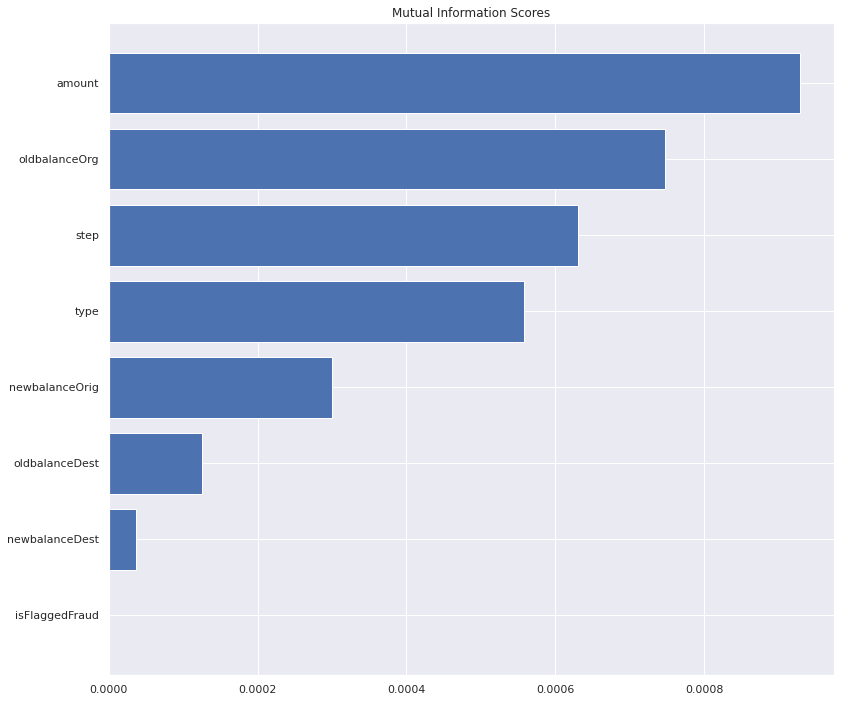

In [11]:
plot_mi_scores(mi_scores)

#### As we can see the amount feature tells the most about the transaction being freudulent or not but the isFlaggedFraud does not so it might be better to just drop that feature

In [12]:
data.drop(['isFlaggedFraud'], axis=1, inplace=True)

#### Before we visualize the rest of the data let's first look at the distribution of the isFraud feature

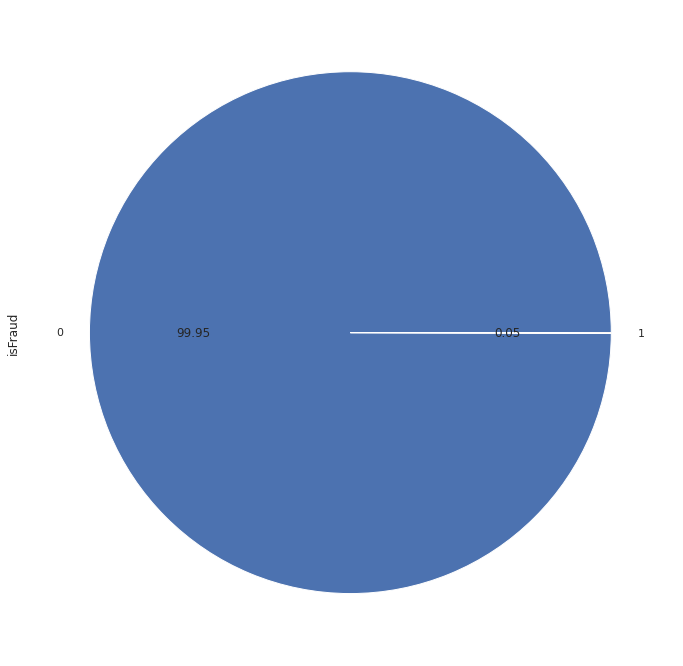

In [13]:
data['isFraud'].value_counts().plot.pie(autopct='%.2f');

#### This is just a proportion of the data but we can assume that the other 500,000 chunks behave more or less the same. So unless the features correctly describe a fraudulent transaction we can expect some bias in our model

#### Now for EDA purposes we can balance the data out. This will take out a lot of data but at the moment we are only interested in understanding it

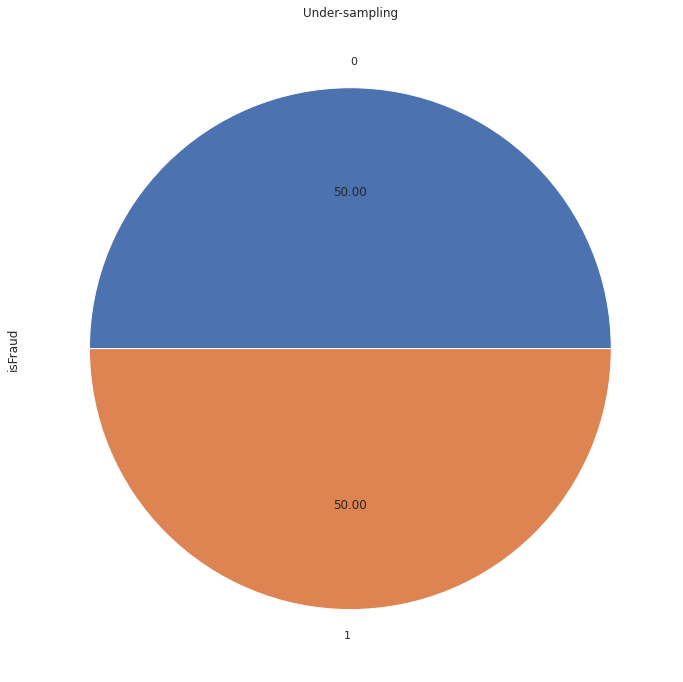

In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1)  # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_balanced, y_train_balanced = rus.fit_resample(data.drop(['isFraud'], axis=1), data['isFraud'])
ax = y_train_balanced.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [15]:
y_train_balanced.shape

(1070,)

#### Now we've got only 466 entries 

### 

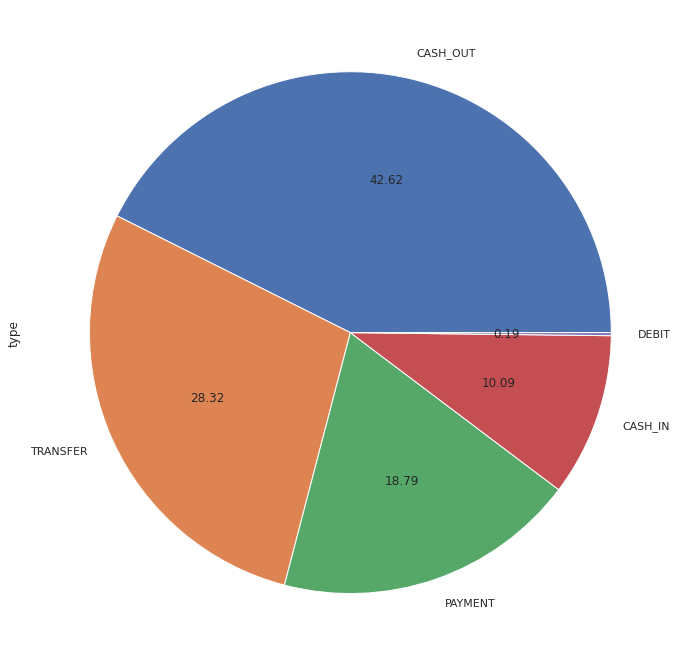

In [16]:
X_train_balanced['type'].value_counts().plot.pie(autopct='%.2f');

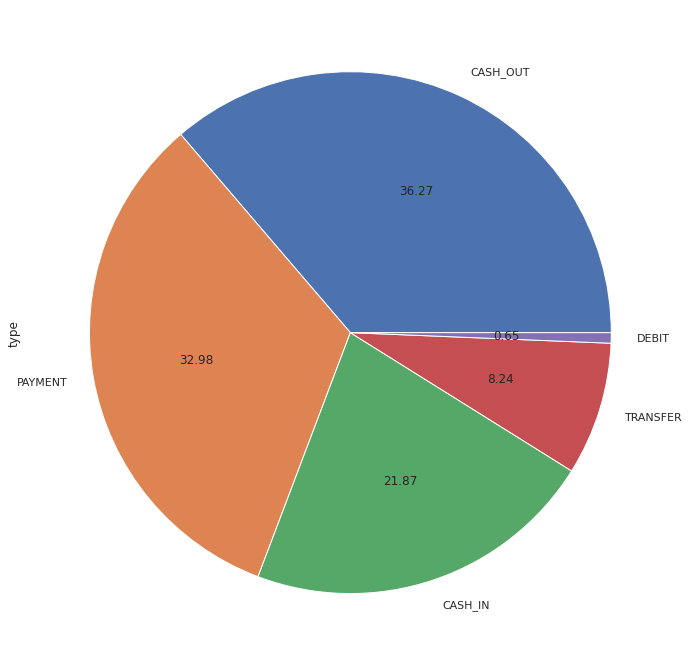

In [17]:
data['type'].value_counts().plot.pie(autopct='%.2f');

#### As we can see the balanced data does a good job of representing the imbalanced data because they both represent a wide set of entries

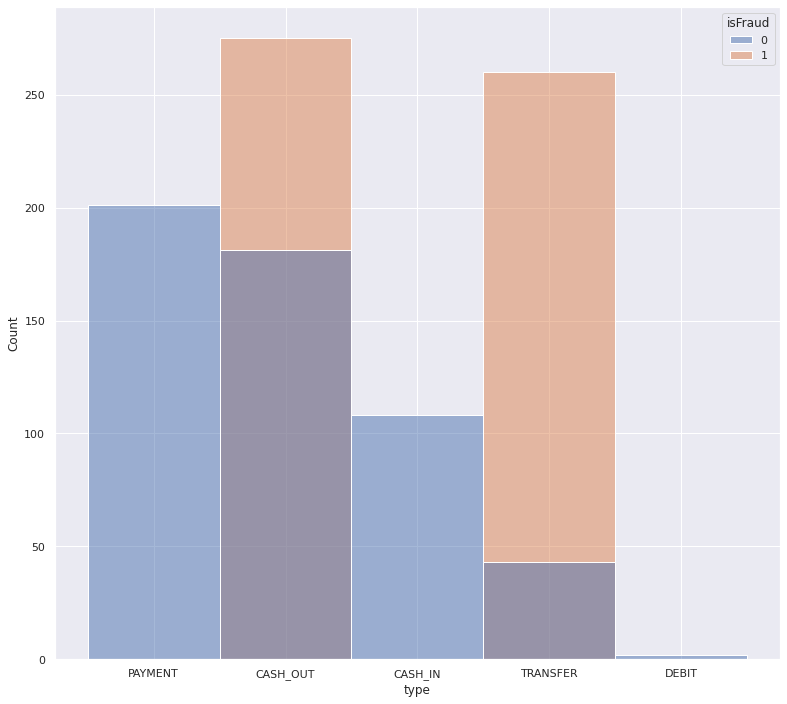

In [18]:
sns.histplot(x=X_train_balanced['type'], hue=y_train_balanced);

#### We can see that almost no fraudulent transactions happen by CASH_IN or PAYMENT or DEBIT. They primarily happen by CASH_OUT and TRANSFER. This does make sense as one would try to tranfer the money to their offshore account for example or just take the cash out directly for a less chance of someone tracing the fraud back to them 

#### There is still a chance we might have overlooked something so let's use the pandas_profiling library to generate some useful insights

In [19]:
X_y_balanced = pd.concat([X_train_balanced, y_train_balanced], axis=1)

In [20]:
from pandas_profiling import ProfileReport


profile = ProfileReport(df=X_y_balanced)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Now that we've generated the report let's look at some interesting aspects in more detail

#### So lets look at the money side of things

#### We can have a look at: amount, oldbalanceOrg,  newbalanceOrg,  oldbalanceDest,  newbalanceDest

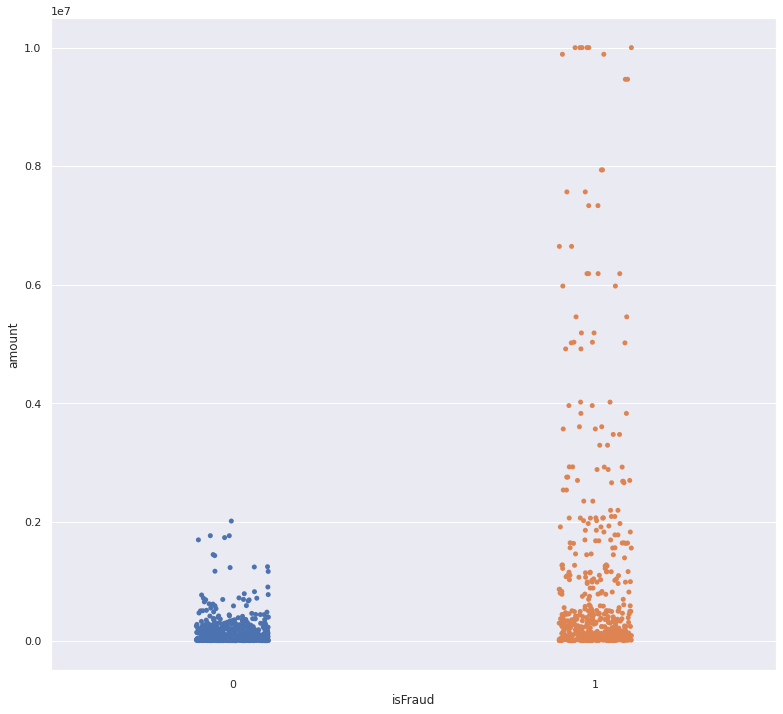

In [21]:
sns.stripplot(y=X_train_balanced['amount'], x=y_train_balanced);

#### Here we can clearly see that the fraudulent transactions tend to come at lower amounts but also very high amounts. This shows that people who commit fraud usually will also try to steal a higher amount at one time. Maybe they think that once they do it, they won't be able to do it again using the same accounts so they better get a big amount of money. People who do not commit fraud don't need to do high amount transactions because they can always go and do another transaction, that is why their transaction amounts are lower in comparison to people who commit fraud.

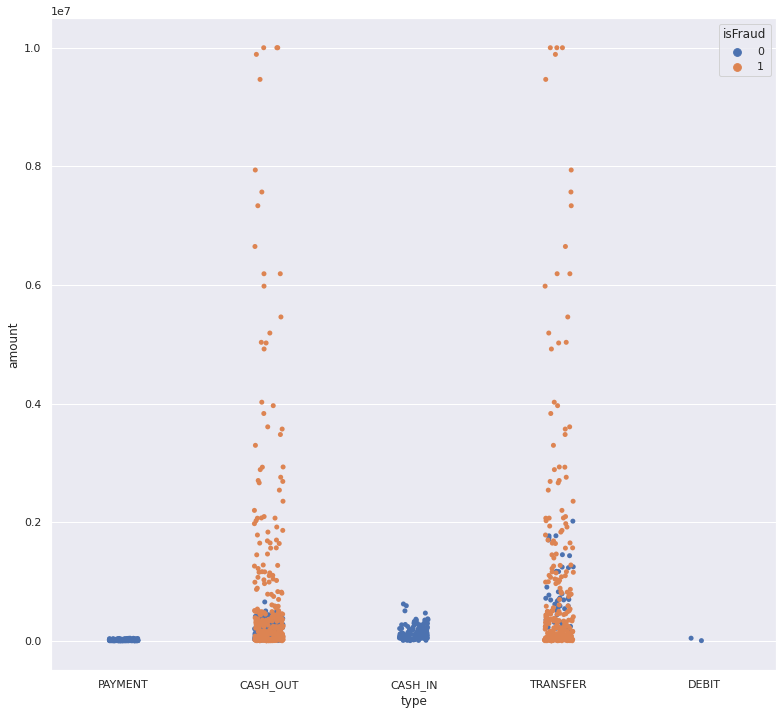

In [22]:
sns.stripplot(y=X_train_balanced['amount'], x=X_train_balanced['type'], hue=y_train_balanced);

#### Here we can again see the types of transactions used for fraud as we've seen in the graph above but we can also see the amount of a transaction in regards to the type of the transaction. We already knew that Cash and Transfer transactions were the types that were used in fraud but we can also see that because those are the ones used for fraud that they are also the types that include the highest money amount

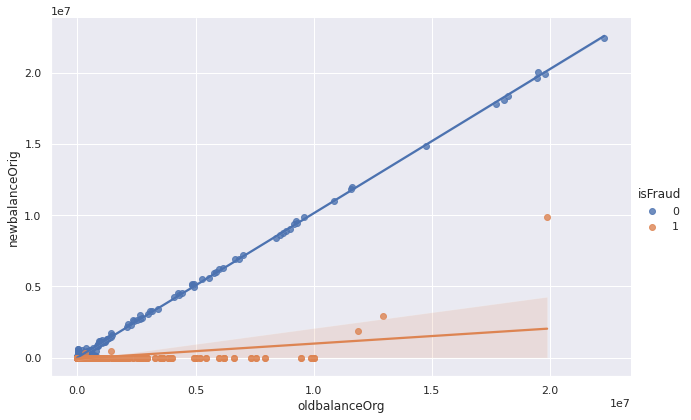

In [23]:
sns.lmplot(data=X_y_balanced, x='oldbalanceOrg',y='newbalanceOrig', hue='isFraud', height=6, aspect=1.5);

#### Because of fraudulent activity we can see that most types of fraud will not reflect on the new balance of the account owner

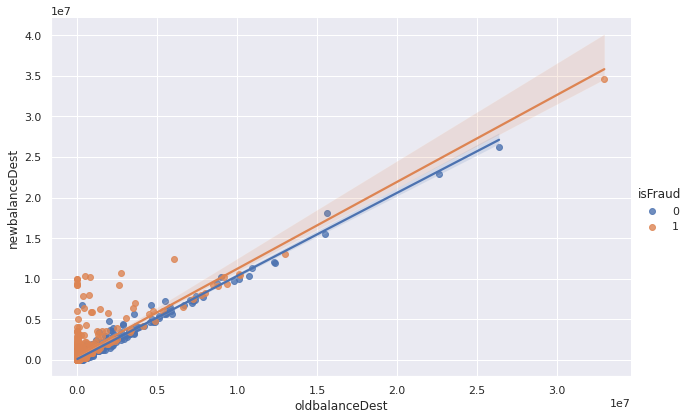

In [24]:
sns.lmplot(data=X_y_balanced, x='oldbalanceDest',y='newbalanceDest', hue='isFraud', height=6, aspect=1.5);

#### But here you can see that fraudulent activity will not be reflected on the thiefs old account balance because they stole the money

#### Now....something I find a bit odd is the Step variable. The step might have a hight Mutual Information (MI) score but that doesn't mean that it's useful. So lets look at it in a better light

#### By definition the step maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

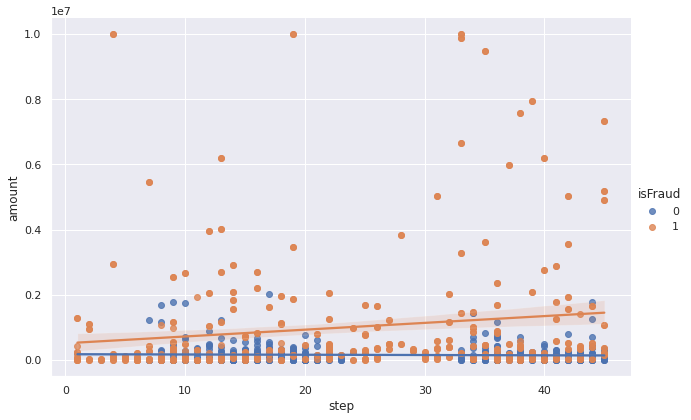

In [25]:
sns.lmplot(data=X_y_balanced, x='step',y='amount', hue='isFraud', height=6, aspect=1.5);

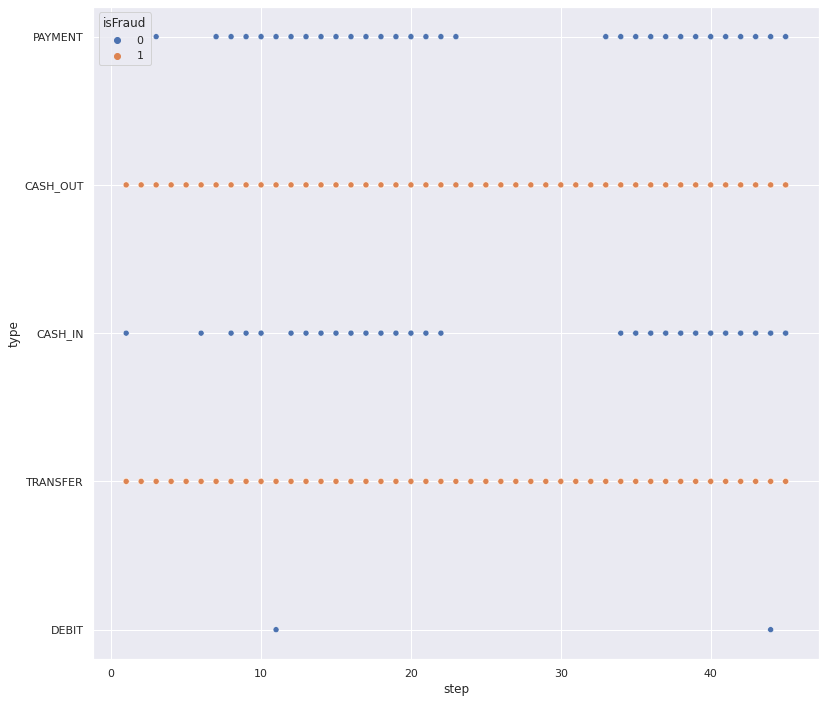

In [26]:
sns.scatterplot(data=X_y_balanced, x='step',y='type', hue='isFraud');

#### There doesn't seem to be a correlation. Because why would there be ? Fraud isn't predictable by time, is it ? So lets drop this column

In [27]:
X_y_balanced.drop(['step'], axis=1, inplace=True);

#### Even the report we generated above does not describe the 'step' as a variable that is correlated with the dependent varibale 'isFraud'

#### Now there might still be an aspect we need to look at more precisely: The possibility of outliers

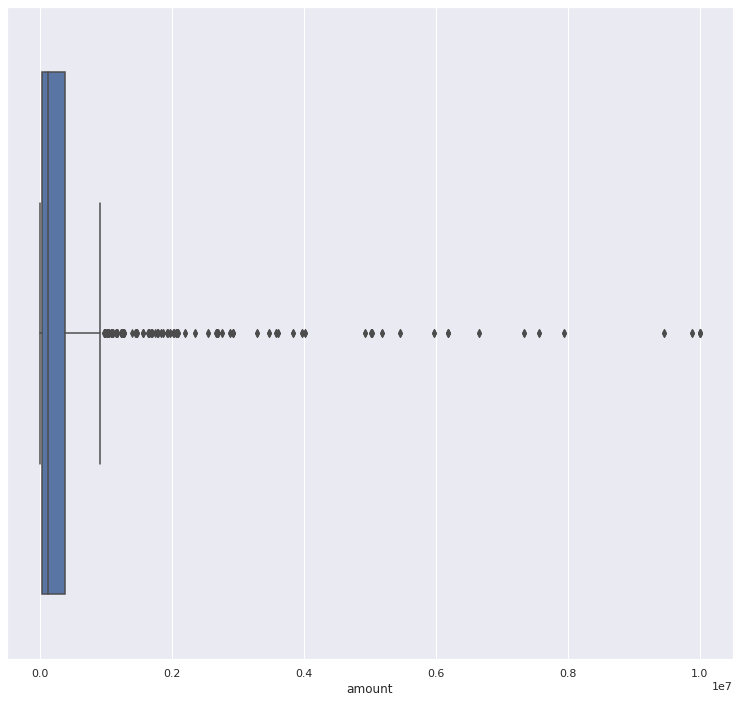

In [28]:
sns.boxplot(x=X_y_balanced['amount'], hue=X_y_balanced['isFraud']);

#### While there are some outliers here most of them look like they are fraud so we''ll keep them

## 4.Feature Engineering

####  We are specifically going to look at oldbalanceOrg and newbalanceOrig to see if we can maybe get the ratio or subtraction as a usefule new feature

In [29]:
old_new_balance_sub = pd.Series((X_y_balanced['oldbalanceOrg'] - X_y_balanced['newbalanceOrig']), name='old_new_balance_sub', index=None)

In [30]:
old_new_balance_sub.head()

0     38120.79
1         0.00
2         0.00
3   -162993.85
4         0.00
Name: old_new_balance_sub, dtype: float64

#### So let's add this feature to our dataframe and calculate the MI scores again

In [31]:
X_y_balanced = pd.concat([X_y_balanced, old_new_balance_sub], axis=1)

In [32]:
X_temp = X_y_balanced.copy()
y_temp = X_y_balanced['isFraud']
mi_scores = make_mi_scores(X_temp, y_temp)

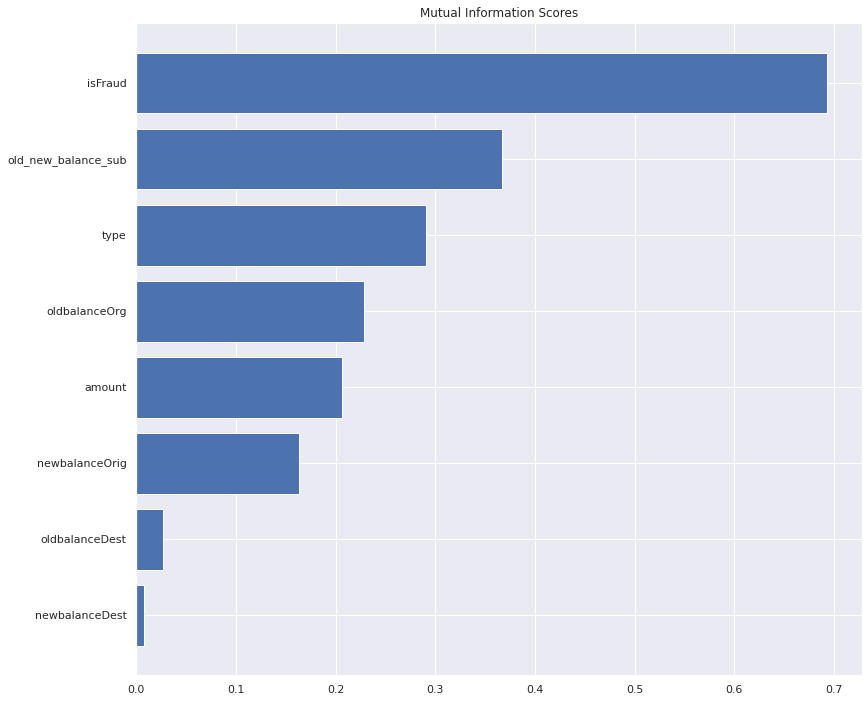

In [33]:
plot_mi_scores(mi_scores)

#### As we can clearly see we have successfully created a new feature that has a large effect on the dependant variable

## 5.Data Processing

#### We've spent some time understanding the data but now lets try to build a model that can predict fraud in the feature
#### We'll only work on a batch of the data but feel free to train it on the entire dataset

In [34]:
X_y_balanced.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,old_new_balance_sub
0,PAYMENT,38120.79,1135015.14,1096894.35,0.00,0.00,0,38120.79
1,CASH_OUT,73689.93,0.00,0.00,292528.42,309162.49,0,0.00
2,CASH_OUT,83022.70,0.00,0.00,393470.41,476493.10,0,0.00
3,CASH_IN,162993.85,5787304.81,5950298.66,536210.64,373216.79,0,-162993.85
4,CASH_OUT,224042.65,0.00,0.00,2190803.53,2354742.19,0,0.00


In [35]:
X = X_y_balanced.drop(['isFraud'], axis=1)
y = X_y_balanced['isFraud']

In [36]:
encoded_types = pd.get_dummies(X['type'])
X.drop(['type'], axis=1, inplace=True)
encoded_types.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [37]:
X = pd.concat([encoded_types, X], axis=1)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [39]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

## 6.Model

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier


#0.92
clf = SGDClassifier()

clf.fit(X=X_train, y=y_train);

In [41]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
M = confusion_matrix(y_true=y_test, y_pred=y_pred)
M

array([[106,   1],
       [ 33,  74]])

In [42]:
from sklearn.metrics import accuracy_score, recall_score

acc = accuracy_score(y_true=y_test, y_pred=y_pred)
rec = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Acc: {acc}')
print(f'Rec: {rec}')

Acc: 0.8411214953271028
Rec: 0.6915887850467289


In [43]:
from sklearn.metrics import f1_score

F_one = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
F_one

0.8411214953271028

In [44]:
from sklearn.model_selection import cross_validate
scores = cross_validate(clf, X_train, y_train, cv = 10, scoring=['accuracy', 'recall', 'f1'])


print(f'Cross-validation scores:{scores}\n')
print(f'Average cross-validation accuracy score: {scores["test_accuracy"].mean()}')
print(f'Average cross-validation recall score: {scores["test_recall"].mean()}')
print(f'Average cross-validation f1 score: {scores["test_f1"].mean()}')


Cross-validation scores:{'fit_time': array([0.00317693, 0.0034759 , 0.00201154, 0.00215197, 0.00297618,
       0.00194597, 0.00189471, 0.00289321, 0.0025053 , 0.00297356]), 'score_time': array([0.00251436, 0.00252199, 0.00243878, 0.00235605, 0.00240684,
       0.0022459 , 0.00222445, 0.00228238, 0.00224495, 0.00229383]), 'test_accuracy': array([0.91860465, 0.91860465, 0.8255814 , 0.8255814 , 0.84883721,
       0.8372093 , 0.89411765, 0.87058824, 0.91764706, 0.90588235]), 'test_recall': array([0.97674419, 0.93023256, 0.95348837, 0.72093023, 0.93023256,
       0.6744186 , 0.92857143, 1.        , 0.88372093, 0.86046512]), 'test_f1': array([0.92307692, 0.91954023, 0.84536082, 0.80519481, 0.86021505,
       0.80555556, 0.89655172, 0.88421053, 0.91566265, 0.90243902])}

Average cross-validation accuracy score: 0.8762653898768811
Average cross-validation recall score: 0.8858803986710964
Average cross-validation f1 score: 0.8757807317664424


## 7.Results

#### Using the SGDClassifier we were able to reach a good model performance but this was only tested with a chunk of the data

#### Now let's have a final walkthrough of what we did:

1. We loaded the data and tried to understan it
2. We cleaned the data and removed faetures that were unimportant
3. We visualized the data which helped us further understand the data at hand
4. We generated a new feature which turned out to be a great predicter
5. We built a model that classified the fraudulent transactions
6. Imbalanced Data leads to a very low recall score which means that the model fails to classify the fraudulent Transactions so we will have to find a way to balance the data. Right now we do Random Undersampling to achieve that which gets us a good result in terms of accuracy and recall but we loose a lot of data